# This notebook is to extract cluster with the most DE from network and run it through embedding

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from functions.eda_functions import *
from functions.subset_network import subset_network
from functions.process_phenotype import *
from functions.network_embedding import *
from functools import reduce
import random
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

FileNotFoundError: [Errno 2] No such file or directory: 'G:/Shared drives/NIAAA_ASSIST/Data/expression_meta.csv'

In [268]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0)
comm_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\network_louvain_default.csv', index_col = 0)

## Subset cluster 4 genes

In [385]:
def get_cluster_df(network_df, community_df, cluster):
    cluster_genes = community_df[community_df.louvain_label == cluster].id
    cluster_tom = network_df[cluster_genes]
    cluster_tom = cluster_tom[cluster_tom.index.isin(cluster_genes)]
    return cluster_tom

In [386]:
cluster3_tom = get_cluster_df(tom_df, comm_df, 3)

In [389]:
cluster4_tom = get_cluster_df(tom_df, comm_df, 4)

In [391]:
# cluster3_tom.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\cluster3_TOM.csv')
# cluster4_tom.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\cluster4_TOM.csv')

In [392]:
cluster3_G = nx.convert_matrix.from_pandas_adjacency(cluster3_tom)
cluster4_G = nx.convert_matrix.from_pandas_adjacency(cluster4_tom)

In [32]:
# cluster4_tom = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\cluster4_TOM.csv', index_col = 0)

In [15]:
deseq = pd.read_excel('G:/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')
deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])

In [398]:
top100_nodes = deseq[deseq.id.isin(cluster4_genes)][['id', 'abs_log2FC']].sort_values('abs_log2FC', ascending = False).reset_index(drop = True)[:100]['id']
random_cluster3_nodes = random.sample(cluster3_tom.columns.tolist(), 100)

## Get top 150 node neighbors from cluster4 with weight cutoff at 0.02 into a graph and join all these graphs

## Get top 150 node neighbors from another cluster with no DE with weight cutoff at 0.02 into a graph and join all these graphs

In [400]:
G_sub_list = []
edges = 0
for gene in top100_nodes:
    gene_subnet = cluster4_tom[gene][cluster4_tom[gene] > 0.02]
    gene_edgelist = pd.DataFrame({'source':gene, 'target':gene_subnet.index, 'weight':gene_subnet.values})
    edges += len(gene_subnet)
    G_sub = nx.convert_matrix.from_pandas_edgelist(gene_edgelist, 'source', 'target', 'weight')
    G_sub_list.append(G_sub)
    
for gene in random_cluster3_nodes:
    gene_subnet = cluster3_tom[gene][cluster3_tom[gene] > 0.02]
    gene_edgelist = pd.DataFrame({'source':gene, 'target':gene_subnet.index, 'weight':gene_subnet.values})
    edges += len(gene_subnet)
    G_sub = nx.convert_matrix.from_pandas_edgelist(gene_edgelist, 'source', 'target', 'weight')
    G_sub_list.append(G_sub)
print('Number of edges:',edges)

Number of edges: 61310


In [401]:
G_joined = reduce(lambda x,y:nx.compose(x, y), G_sub_list)

In [417]:
cluster3_n_4_df = nx.convert_matrix.to_pandas_adjacency(G_joined)

In [253]:
# cluster4_ego_df.to_csv('G:/Shared drives/NIAAA_ASSIST/Data/cluster4_ego_df.csv')

# Check scale-free assumption

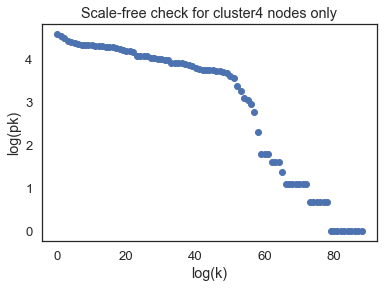

In [404]:
scale_free_validate(cluster4_ego_df, 'cluster4 nodes only')

# Compare whole and subnetwork distance

In [257]:
network_IDs = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\network_IDs.csv', index_col = 0)

In [422]:
# Make a new df for cluster4 ego df to add back the nodes that were in the whole network
cluster3_n_4_no_cutout = cluster3_n_4_df.copy()
# the nodes that were cut out (non cluster 4 subset genes)
cutout_nodes = list(set(network_IDs['0']) - set(cluster3_n_4_df.columns))
col_w_zeros = np.zeros((len(cluster3_n_4_df), len(cutout_nodes))) # 0 to fill the gene columns that aren't in cluster 4
cluster3_n_4_no_cutout[cutout_nodes] = col_w_zeros

In [423]:
# df with 0 to fill the gene rows that aren't in cluster 4
to_stack = pd.DataFrame(0, columns = cluster3_n_4_no_cutout.columns, index = cutout_nodes)
cluster3_n_4_no_cutout = pd.concat([cluster3_n_4_no_cutout, to_stack])

In [269]:
# subset networks that keep the edges to compare network distances
subset10k, G = subset_network(tom_df, 0.218, 0.98)

Number of edges left: 10100.0


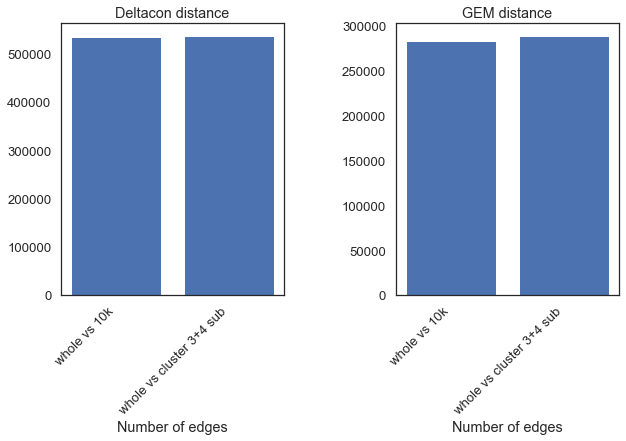

In [426]:
plot_graph_distance([tom_df, subset10k, cluster3_n_4_no_cutout], ['whole', '10k', 'cluster 3+4 sub'])

# Run embedding

In [405]:
cluster4_emb = network_embedding(G_joined, 16, 300, 10, 'C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec1', 'cluster4')

Generating walks (CPU: 1): 100%|██████████████| 300/300 [44:40<00:00,  8.93s/it]


embedding data saved


In [428]:
parameters = []
kmeans_list = []
for length in [16, 64]:
    for num_walk in [100, 300]:
        emb_df = network_embedding(G_joined, length, num_walk, 10, 'C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec1', 'cluster3+4') # use the network with 5k edges as a test (less computationally intensive)
        kmeans_list.append(run_kmeans(emb_df, 2)) # run k means 
        parameters.append(f'length={length},num_walk={num_walk}') # add the parameter name to the parameters list

Computing transition probabilities:   0%|              | 0/3350 [00:00<?, ?it/s]

embedding data saved


Computing transition probabilities:   0%|              | 0/3350 [00:00<?, ?it/s]

embedding data saved


Computing transition probabilities:   0%|              | 0/3350 [00:00<?, ?it/s]

embedding data saved


Generating walks (CPU: 1): 100%|████████████| 300/300 [1:17:06<00:00, 15.42s/it]


embedding data saved


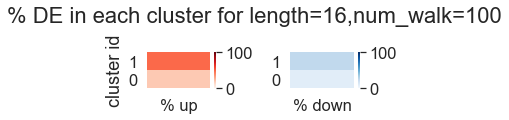

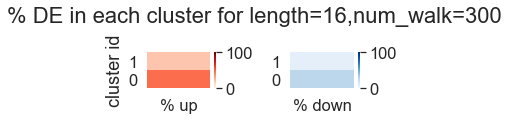

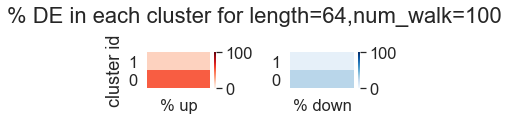

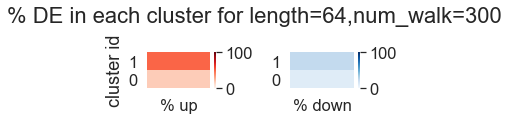

In [429]:
for i in range(len(kmeans_list)):
    cluster_DE_perc(kmeans_list[i], 'kmean_label', parameters[i])

In [383]:
import umap
def umap_embedding(emb_df):
    umap_emb = umap.UMAP(n_neighbors = 8, min_dist = 0.3, random_state=42).fit_transform(emb_df)
    umap_df = pd.DataFrame(umap_emb, index = emb_df.index)
    umap_deseq_df = pd.merge(umap_df, deseq, left_index = True, right_on = 'id')
    sns.set(rc={'figure.figsize':(6,4)})
    sns.set(font_scale = 1.2)
    sns.set_style('white')
    cmap = sns.color_palette('RdBu_r', as_cmap=True)
    f, ax = plt.subplots()
    points = ax.scatter(umap_deseq_df.loc[:,0], umap_deseq_df.loc[:,1], c=umap_deseq_df.loc[:,'log2FoldChange'], 
                        s=2, cmap=cmap, vmin = -0.3, vmax = 0.3)
    f.colorbar(points)
    plt.title('network embedding color by log2FC');

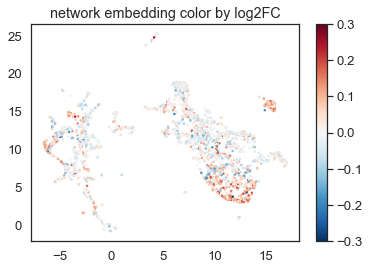

In [430]:
umap_embedding(cluster4_emb)

In [ ]:
# Determine impact vs non-impact proportion and down sample the large group

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [11]:
cluster4_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\assist\data\embedding_Nov28\embedded_len16_walk300_cluster4.csv',
                           index_col = 0)

In [ ]:
parameters = []
kmeans_list = []
for length in [16, 64]:
    for num_walk in [100, 300]:
        emb_df = network_embedding(G_joined, length, num_walk, 10, 'C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec1', 'cluster3+4') # use the network with 5k edges as a test (less computationally intensive)
        kmeans_list.append(run_kmeans(emb_df, 2)) # run k means 
        parameters.append(f'length={length},num_walk={num_walk}') # add the parameter name to the parameters list

In [8]:
os.chdir('C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Dec1')
emb_dfs = []
for file in os.listdir():
    emb = pd.read_csv(file, index_col = 0)
    emb_dfs.append(emb)

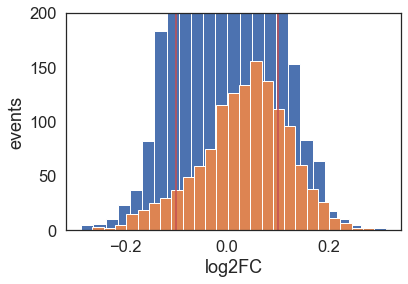

In [356]:
# checking log2FC distribution from deseq and cluster 4 
plt.hist(deseq.log2FoldChange, bins = 25)
plt.hist(deseq[deseq.id.isin(cluster4_emb_labeled.id)].log2FoldChange, bins = 25)
plt.ylim(0, 200)
plt.vlines(-0.1, 0, 200, color = 'r')
plt.vlines(0.1, 0, 200, color = 'r')
plt.ylabel('events')
plt.xlabel('log2FC');

In [411]:
cluster4_emb_labeled = pd.merge(cluster4_emb, deseq, left_index = True, right_on = 'id')
cluster4_emb_labeled['impact'] = 1
cluster4_emb_labeled.loc[cluster4_emb_labeled['log2FoldChange'].between(-0.1, 0.1), 'impact'] = 0

In [10]:
def process_emb_for_ML(embedding_df):
    embedding_labeled_df = pd.merge(embedding_df, deseq, left_index = True, right_on = 'id')
    embedding_labeled_df['impact'] = 1
    embedding_labeled_df.loc[embedding_labeled_df['log2FoldChange'].between(-0.1, 0.1), 'impact'] = 0
    return embedding_labeled_df

In [16]:
processed_emb_dfs = list(map(process_emb_for_ML, emb_dfs))

In [11]:
lr = LogisticRegression(max_iter = 1000)
rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1)
XGB = xgb.XGBClassifier()

Best score 0.7337662337662337


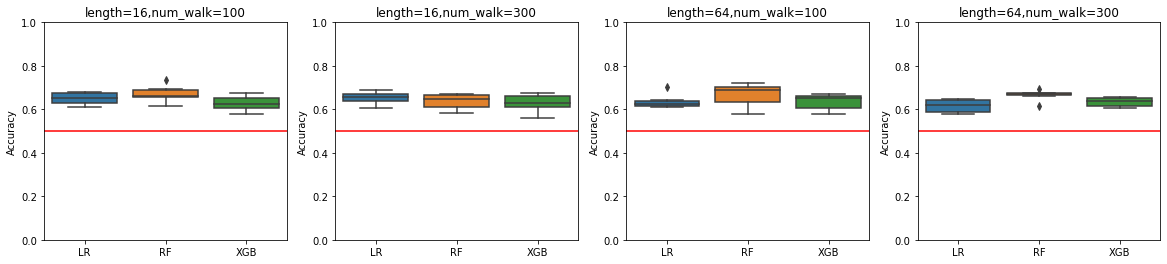

In [48]:
plt.figure(figsize=(20,4))
max_acc = []
for i, emb in enumerate(processed_emb_dfs):
    lr_scores = []
    rf_scores = []
    xgb_scores = []
    for j in range(6):
        emb_sampled = emb.groupby('impact').sample(383).reset_index()
        X_train, X_test, y_train, y_test = train_test_split(emb_sampled.iloc[:,:64], emb_sampled['impact'], test_size = 0.2)
        lr.fit(X_train, y_train)
        rf.fit(X_train, y_train)
        XGB.fit(X_train, y_train)
        lr_scores.append(lr.score(X_test, y_test))
        rf_scores.append(rf.score(X_test, y_test))
        predictions = XGB.predict(X_test)
        xgb_scores.append(accuracy_score(y_test, predictions))
    max_score = max([max(lr_scores), max(rf_scores), max(xgb_scores)])
    max_acc.append(max_score)
    plt.subplot(1,4,i+1)
    sns.boxplot(data=[lr_scores, rf_scores, xgb_scores])
    plt.title(parameters[i])
    plt.xticks((0,1,2), ['LR', 'RF', 'XGB'])
    plt.ylabel('Accuracy')
    plt.hlines(0.5, -0.5, 2.5, color = 'r')
    plt.ylim(0, 1)
print('Best score', max(max_acc))